# Objective

This is to show and compare local runs for the `Ai-for-Astronmy` lab, concerned with
* different batch sizes
* different data sizes
* any starting graphs for a baseline

There are different machines on our team, try to show different machine info

## This to try

### 

In [1]:
# !pip install tensorflow
# not strictly necessary consider only for notebook or adding to requirements.txt[dev]

# make sure astronomy for ai is updated
# !cd ..// && make update_Astronomy_AI

In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import platform
import psutil
import tensorflow as tf
import seaborn as sns
import yaml

from cosmicai.inference import CosmicAI
import warnings

# some model weight warnings
warnings.filterwarnings("ignore")

with open("../keys/aws_credentials.yaml", "r") as f:
    credentials = yaml.safe_load(f)

plt.rcParams["figure.figsize"] = (11, 8)

print(sys.version)
print(tf.__version__)

3.11.8 (v3.11.8:db85d51d3e, Feb  6 2024, 18:02:37) [Clang 13.0.0 (clang-1300.0.29.30)]
2.18.0


In [3]:
print(platform.system()) # mac - Darwin
print(platform.processor()) # cpu

# Get system memory info
memory = psutil.virtual_memory()
print(f"Total Memory: {memory.total / (1024 ** 3):.2f} GB")
print(f"Available Memory: {memory.available / (1024 ** 3):.2f} GB")
print(f"Used Memory: {memory.used / (1024 ** 3):.2f} GB")
print(f"Free Memory: {memory.free / (1024 ** 3):.2f} GB")

devices = tf.config.list_physical_devices()
print(devices) # only cpu on local


Darwin
arm
Total Memory: 48.00 GB
Available Memory: 21.48 GB
Used Memory: 15.89 GB
Free Memory: 6.35 GB
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Load the Cosmic AI instance

In [23]:
!du -h ../data/models/default_model_data/resized_inference.pt # data size
!du -h ../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt # model size

 25M	../data/models/default_model_data/resized_inference.pt
 61M	../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt


In [6]:
cosmic = CosmicAI()
cosmic.load_data() 
cosmic.load_model()

loading data from - ../data/raw/resized_inference.pt
loading the model from  ../data/models/Mixed_Inception_z_VITAE_Base_Img_Full_New_Full.pt


### Visualize the Model Weights
***

* `!pip install torch-summary`
* keras style visualizer, not required and shouldn't be loaded with requirements just visualizing

In [7]:
from torchsummary import summary

summary(cosmic.model)

Layer (type:depth-idx)                   Param #
├─LayerNorm: 1-1                         384
├─Linear: 1-2                            37,056
├─Input_Mix_Model: 1-3                   --
|    └─Conv2d: 2-1                       192
|    └─AvgPool2d: 2-2                    --
|    └─AvgPool2d: 2-3                    --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-1                  6,144
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,049,600
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  1,049,600
|    |    └─ReLU: 3-6                    --
|    |    └─Linear: 3-7                  1,049,600
|    |    └─ReLU: 3-8                    --
|    |    └─Linear: 3-9                  1,049,600
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-10                 (recursive)
|    |    └─AvgPool2d: 3-11              --
|    |    └─InceptionBlock: 3-12         11,040
|    |    └─Inception

Layer (type:depth-idx)                   Param #
├─LayerNorm: 1-1                         384
├─Linear: 1-2                            37,056
├─Input_Mix_Model: 1-3                   --
|    └─Conv2d: 2-1                       192
|    └─AvgPool2d: 2-2                    --
|    └─AvgPool2d: 2-3                    --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-1                  6,144
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,049,600
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  1,049,600
|    |    └─ReLU: 3-6                    --
|    |    └─Linear: 3-7                  1,049,600
|    |    └─ReLU: 3-8                    --
|    |    └─Linear: 3-9                  1,049,600
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-10                 (recursive)
|    |    └─AvgPool2d: 3-11              --
|    |    └─InceptionBlock: 3-12         11,040
|    |    └─Inception

## Run the Model
* default data loaded, trying to get a baseline

In [8]:
cosmic.run_inference()

{'total_cpu_time': 14.384935184999893,
 'total_cpu_memory': 29616.327912,
 'execution_time_per_batch': 4.794978394999965,
 'num_batches': 3,
 'batch_size': 512,
 'device': 'cpu',
 'throughput_bps': 14299159.318735681}

## Vary the Batch Sizes
***

### Batch Sizes
* `512` is the baseline already run above

```yaml
small: [8, 16, 32, 64]
medium: [128, 256]
large: [`512`, 1024, 2048]
```

In [13]:
batch_report_ = []

for n in [8, 16, 32, 64,128, 256, 512, 1024, 2048]:
    print(f"running - batch size - {n}")
    cosmic.set_batch_size(n)
    results = cosmic.run_inference()
    batch_report_.append(results)


running - batch 8
running - batch 16
running - batch 32
running - batch 64
running - batch 128
running - batch 256
running - batch 512
running - batch 1024
running - batch 2048


In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) # change scientific notation

df_baseline = pd.DataFrame(batch_report_) # input: list of dicts
df_baseline = df_baseline.assign(throughput_mbps = df_baseline["throughput_bps"].div(1000000.0)) # bps -> mbps

# save out
df_baseline.to_csv("..//data/interim/baseline_vary_batch.csv", index=False)

# throughput is the rate at which a model processes data
# more complex models have a higher through put
df_baseline



,total_cpu_time,total_cpu_memory,execution_time_per_batch,num_batches,batch_size,device,throughput_bps,throughput_mbps
0,28.03,31920.99,0.18,157,8,cpu,7337396.77,7.34
1,26.95,29317.05,0.34,79,16,cpu,7632346.09,7.63
2,20.54,29319.14,0.51,40,32,cpu,10013069.58,10.01
3,17.59,29388.88,0.88,20,64,cpu,11695535.96,11.70
4,16.33,29490.16,1.63,10,128,cpu,12595033.08,12.60
5,14.73,29522.15,2.95,5,256,cpu,13959847.83,13.96
6,14.70,29632.71,4.90,3,512,cpu,13988292.56,13.99
7,13.40,29661.96,6.70,2,1024,cpu,15345405.14,15.35
8,12.66,29751.66,12.66,1,2048,cpu,16253763.89,16.25


Text(0.5, 1.0, 'cpu size vs batch size')

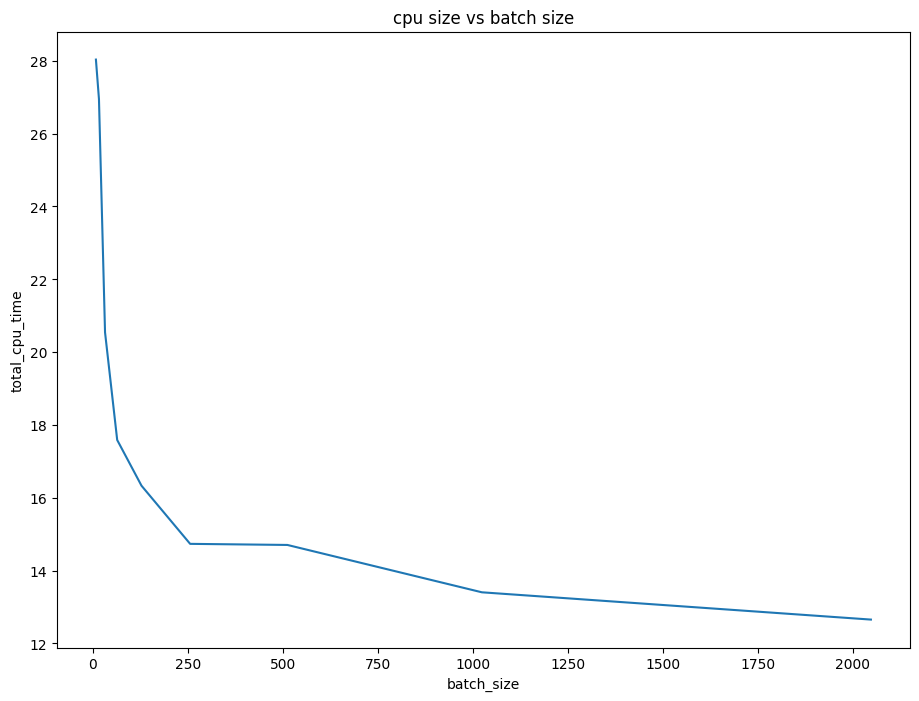

In [31]:
# total cpu size vs batch size
sns.lineplot(data=df_baseline, x = "batch_size", y = "total_cpu_time").set_title("CPU TIME vs Batch size")

Text(0.5, 1.0, 'CPU TIME vs Batch size')

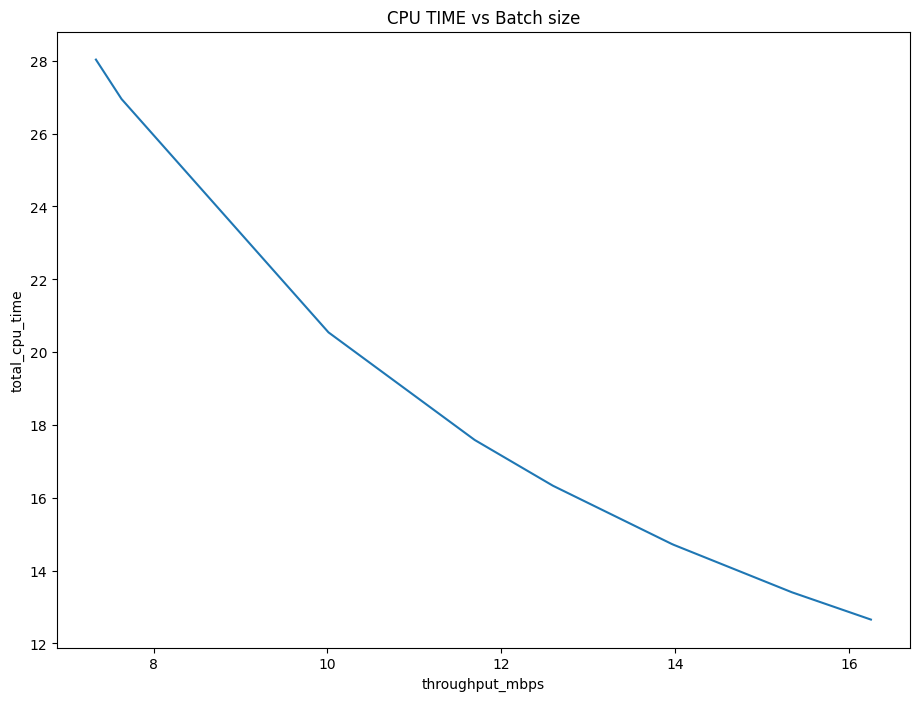

In [35]:
# increasing the batch size increases the throughput
sns.lineplot(data=df_baseline, x = "throughput_mbps", y = "total_cpu_time").set_title("CPU TIME vs Batch size")

## Try on different sized data

In [10]:
# 1) download data 
    # data should be stored in raw and can't be uploaded

# 2) run the model on the data

# 3) set parameters for the run and collect them